# Run Q3Dfit from this Jupyter Notebook in Astroconda Environment.

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.1. Setting up the directory tree](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)        
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)



<font color='red'>We need to decide where the makeqsotemplate functionality goes. </font>

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import os
import numpy as np
from q3dfit.common.questfit_readcf import readcf

### 1.1. Setting up the directory tree <a class="anchor" id="chapter1_1"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [2]:
# book-keeping variables (unique to the user)
# Input files
volume = '../../../MIRISIM/MIRI-ETC-SIM/' # base directory
infile = volume+'miri_etc_cube.fits' # path + name of your input cube
cfinfile = '../test/test_questfit/miritest.cf'
qsotemplate = '../data/questfit_templates/miri_qsotemplate.npy'

# Output directories/files
outdir = volume+'outputs/' # path + name of directory for saving the output files
logfile = outdir+'miritest_fitlog.txt' # path to output logfile
path_to_npy_file = outdir # path for initproc.npy



Some general information about your cube:

In [3]:
ncols = 16
nrows = 25
fitrange = [11.53050463,13.47485667] # in micron
if not os.path.isfile(infile): 
    print('Data cube not found.')
if not os.path.isfile(cfinfile):
    print('Configuration file not found.')
else:
    config_file = readcf(cfinfile)
### Point to QSO template. If this does not yet exist, it will be generated from the cube.
if not os.path.exists(qsotemplate):
    from q3dfit.common.makeqsotemplate import makeqsotemplate
    makeqsotemplate(infile, qsotemplate, dataext=1, varext=2, dqext=3, waveext=None) 

In [4]:
dict_argsreadcube = {'wmapext': None,
                    'waveunit_in': 'Angstrom',
                    'fluxunit_in': 'Jy',}
#dict_argsreadcube = {'waveunit_in': 'Angstrom',
#                    'fluxunit_in': 'Jy',}
#wmapext = None

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelist <font color='red'>provide reference here</font>.

In [5]:
lines = ['[NeII]12.81']

How many components do you want to be fitted to the emission lines?

In [6]:
maxncomp = 1

In [7]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    linetie[i] = '[NeII]12.81'
    ncomp[i] = np.full((ncols,nrows),maxncomp)
    zinit_gas[i] = np.full((ncols,nrows,maxncomp),0.)
    siginit_gas[i] = np.full(maxncomp, 500.)
    zinit_stars=np.full((ncols,nrows),0.0)
maskwidths_def = 2000 # half-width in km/s for emission line masking during the continuum fit

In [8]:
zsys_gas = 0.0
siglim_gas = np.array([5., 1000.])

For a description of continuum fitting parameters in the .cf file, please see the documentation: 
https://q3dfit.readthedocs.io/en/latest/

In [9]:
fcncontfit = 'questfit'

#else:
#    questfit_config = readcf(cfinfile)

argscontfit = dict()
argscontfit['config_file'] = cfinfile
argscontfit['models_dictionary'] = {}
argscontfit['template_dictionary'] = {}
argscontfit['outdir'] = outdir
decompose_qso_fit = True

#### 1.2.4. Wavelength-dependent spectral convolution <a class="anchor" id="chapter1_2_4"></a>
If no convolution is desired, then set `spectres_convolve` to None.  
If convolution is desired, then `spectres_convolve` and `spect_instrum` are required. 
Specify the desired convolution method as the dictionary key, which should mirror the filename in /data/dispersion_files, and the dictionary elements should specify the grating, spectral resolution, or velocity.

e.g. to convolve spectrum with JWST NIRSPEC / G140M, then set `spect_instrum = {'JWST_NIRSPEC':['G140M']}`

In [10]:
spect_instrum = {'flat':['R4666']}
spectres_convolve = None
#spectres_convolve = {'ws_instrum':spect_instrum}

One dictionary must be defined for a line plot to appear. `argspltlin1` holds the options for the first line plot, and `argspltlin2` is for the second. Parameter options are fed in as keyword/data pairs.

Required keywords in each dictionary:
* `nx`: Number of subplots in the horizontal direction
* `ny`: Number of subplots in the vertical direction
* Options for centerting the plot:
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame

Optional keywords:
* `size`: float list of widths in wavelength space of each subplot; if not specified, default is 300 $Å$
* `IR`: set to `True` to use infrared-style plot

In [11]:
argspltlin1 = {'nx': 1,
               'ny': 1,
               'line': lines,
               'size': [1.]}

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [12]:
initproc = { \
            # Required pars
            'fcninitpar': 'parinit',
            'fitran': fitrange,
            'infile': infile,
            'label': config_file['source'][0].replace('.ideos','').replace('.npy', ''),
            'lines': lines,
            'linetie': linetie,
            'maxncomp': maxncomp,
            'ncomp': ncomp,
            'outdir': outdir,
            'zinit_stars': zinit_stars,
            'zinit_gas': zinit_gas,
            'zsys_gas': zsys_gas,
            'spect_convol':spectres_convolve,
            # Optional pars
            'argsreadcube': dict_argsreadcube,  
            'fcncontfit': fcncontfit,
            'argscontfit': argscontfit,
            'argspltlin1': argspltlin1,
            'fcncheckcomp': 'checkcomp',
            'maskwidths_def': maskwidths_def,
            'logfile': logfile,
            'siglim_gas': siglim_gas,
            'siginit_gas': siginit_gas,
            'decompose_qso_fit': decompose_qso_fit
           }

If you want to run `q3dfit` in batch mode, run this cell, which saves initproc to an `npy` file. In your python command line, read in that `npy` file with
<pre><code>import numpy as np
initproc = np.load('path/to/the/npy/file/initproc.npy',allow_pickle=True)</code></pre>
and then run `q3dfit` with 
<pre><code>from q3dfit.common.q3df
import q3df q3df(initproc[()],cols=cols,rows=rows)</code></pre>

In [13]:
initproc_npy = 'initproc.npy'
np.save(path_to_npy_file+initproc_npy,initproc)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [14]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [15]:
cols = [6]
rows = [12]

In [16]:
q3df(initproc, cols=cols, rows=rows, quiet=False)

FITLOOP: First call to FITSPEC
1.0
1
[[Variables]]
    template_0_amp:        0.07375000 (init = 0.059)
    template_0_multpolyA:  1.96194262 (init = 1)
    template_0_multpolyB:  0.03654590 (init = 1)
    template_0_multpolyC:  1.99999758 (init = 0.1)
    template_1_amp:        0.04411574 (init = 0.175)
    blackbody250a:         0.00868853 (init = 0.1)
    blackbody250T:         2999.50146 (init = 250)
    global_ext_Av:         0.50473262 (init = 0)
    global_ice_tau:        1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.6 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1431e+01                                    1.88e+01    
       1              2         2.0455e+01      9.76e-01       1.37e+02       4.40e+00    
       2              3         2.0437e+01      1.85e-02       4.80e+00       2.79e-02    
       3              4         2.0436e+01      3.79e-04       7.62e+00       3.22e-02    
    

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

Column 6 of 16
    Row 12 of 25


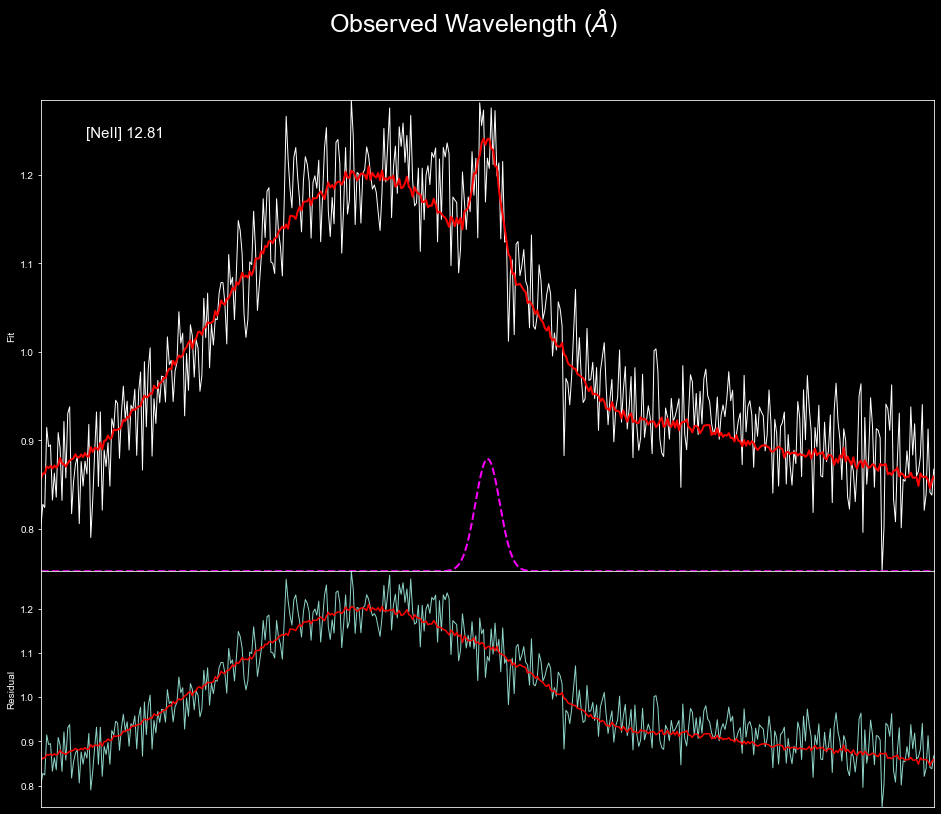

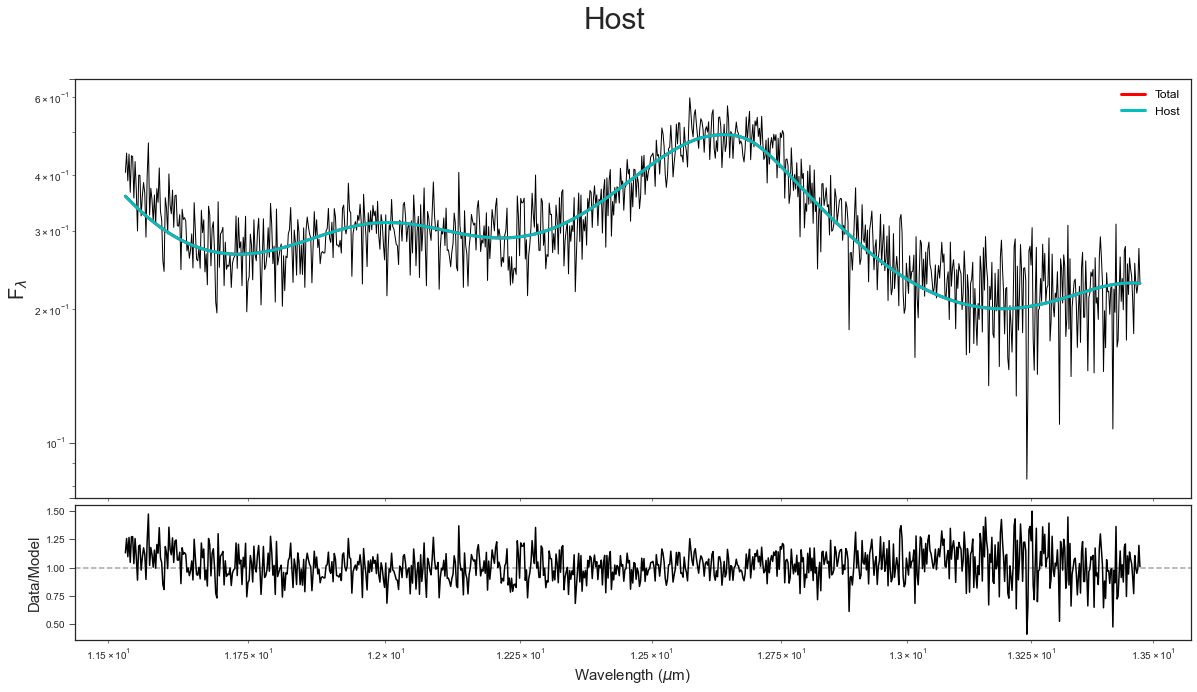

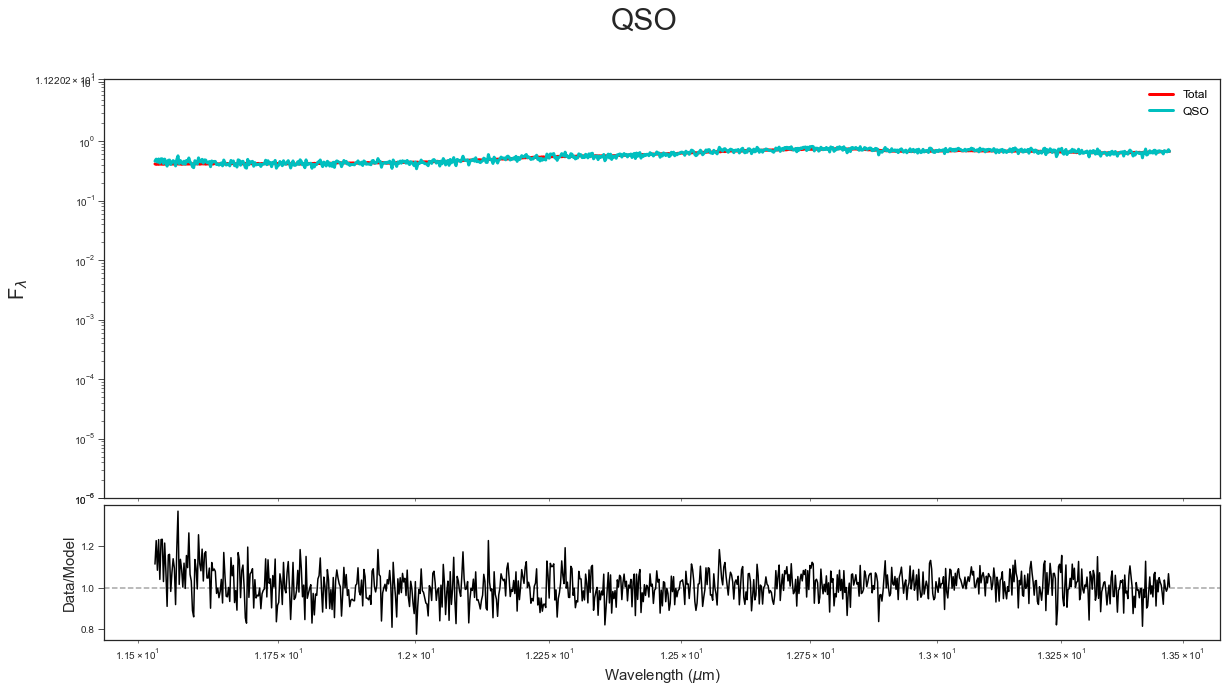

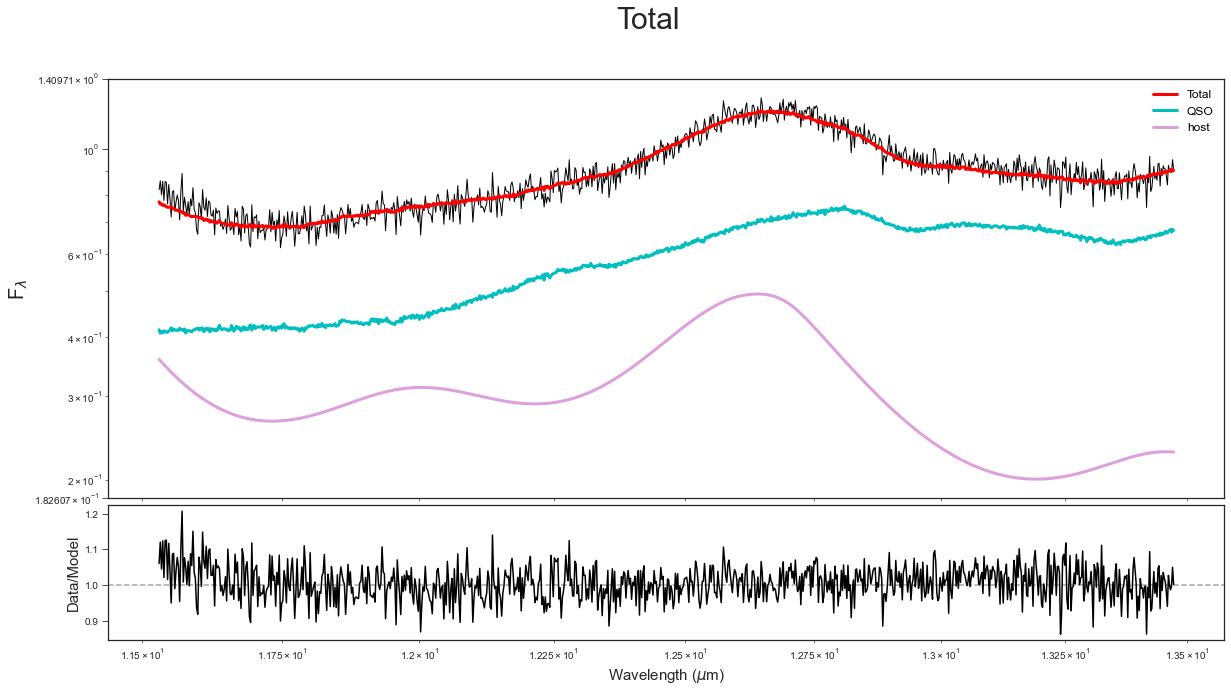

In [17]:
%matplotlib inline
q3da(initproc, cols=cols, rows=rows, quiet=False)